Check normalization ...... 0.005 sec
0.9999999999999998 1.0000000000000002
Calculating matrix elements ...... 0.889 sec
Calculating eigenvalues ...... 0.04 sec
Calculating eigenfunctions ...... 0.609 sec
0 0.5000495049707536
1 1.5001475144968077
2 2.5002435242912227
3 3.5003375324575994
4 4.5004295422704645
5 5.500519548734103
6 6.500607558770679
7 7.50069356327801
8 8.500777573708834
9 9.500859576042032
---DONE---


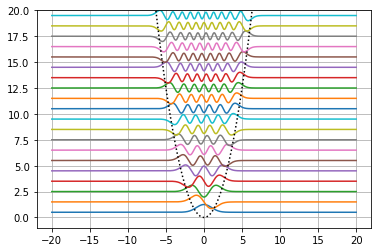

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy 
import time
#%matplotlib notebook
%matplotlib inline

Lx=20.0
nx=10000
dx = 2*Lx/nx

m    = 1.0
hbar = 1.0
w    = 1.0

def testFunctions(x):
    testFuncs = []
    alpha = 1.0
    paramMin=1
    paramMax=100
    nbrPoints = (paramMax-paramMin)+1
    param = np.linspace(paramMin, paramMax, nbrPoints)

    testFuncs.append(np.sqrt(1/(2*Lx))*np.ones(len(x)))
    for n in param:
        bump = np.sqrt(1/Lx)*np.sin(2*np.pi*n*x/(2*Lx))
        testFuncs.append(bump)
        bump = np.sqrt(1/Lx)*np.cos(2*np.pi*n*x/(2*Lx))
        testFuncs.append(bump)
    startTime = time.time()
    print('Check normalization ...', end = '')
    norms = [integrate(x, np.multiply(testFuncs[n],testFuncs[n])) for n in range(len(param))]
    print('...', round(time.time() - startTime,3), 'sec')
    print(min(norms),max(norms))
    return testFuncs

def integrate(x,fx):
    #trapeziod rule
    integral = np.trapz(fx,x)
    #integral = scipy.integrate.simps(fx, x)
    return integral

def secondDeriv(x,f):
    g=np.convolve(f,[1,-2,1],mode='valid')/np.square(dx)
    g=np.append(g,g[-1])
    g=np.insert(g,0,g[0])
    return g

def getPotential(x):
    preFac2 =  0.5*m*w*w
    x2      =  np.square(x)
    pot     =  np.multiply(preFac2,x2)
    return pot 

def applyHamiltonian(x,f):
    # H = -hbar^2/2m dxdx + m*w^2/2*x^2
    preFac1 = -0.5*hbar*hbar/m
    Hpsi = np.multiply(preFac1,secondDeriv(x,f))+np.multiply(getPotential(x),f)
    return Hpsi

def buildHamiltonMatrix(x,testFuncs):
    n   = len(testFuncs)
    gHf = np.zeros((n, n))
    startTime = time.time()
    print('Calculating matrix elements ...', end = '')
    for i,f in enumerate(testFuncs):
        Hf = applyHamiltonian(x,f)
        for j,g in enumerate(testFuncs[:i+1]):
            psi = np.multiply(g,Hf)
            matrixElement = integrate(x,psi)
            gHf[i][j] = matrixElement
            gHf[j][i] = matrixElement
    print('...', round(time.time() - startTime,3), 'sec')

    startTime = time.time()
    print('Calculating eigenvalues ...', end = '')
    eigenValues,eigenVectors = LA.eig(gHf)
    print('...', round(time.time() - startTime,3), 'sec')
    
    #constructing eingenFunctions
    startTime = time.time()
    print('Calculating eigenfunctions ...', end = '')
    eigenFunctions = []
    for n in range(len(eigenValues)):
        ef = len(x)*[0]
        for i, testFunc in enumerate(testFuncs):
            ef = np.add(ef,np.multiply(eigenVectors[i][n],testFuncs[i]))
        eigenFunctions.append(ef)
    print('...', round(time.time() - startTime,3), 'sec')
    
    #sort eigenValues AND eigenVectors
    idx = eigenValues.argsort()[::1]
    eigenValues    = eigenValues[idx]
    eigenVectors   = eigenVectors[:,idx]
    eigenFunctions = [eigenFunctions[i] for i in idx]
    
    return eigenValues, eigenVectors, eigenFunctions

def run():
    xGrid = np.linspace(-Lx, Lx, nx)
    testFuncs = testFunctions(xGrid)
    eigenValues, eigenVectors, eigenFunctions = buildHamiltonMatrix(xGrid,testFuncs)
    
    for i, ef in enumerate(eigenFunctions[:20]):
        plt.plot(xGrid,ef+eigenValues[i])
    plt.plot(xGrid,getPotential(xGrid),linestyle=':',color='black')
    plt.ylim((-1,20))
    plt.grid()
    for i, ev in enumerate(eigenValues[:10]):
        print(i, ev)
    
    print('---DONE---')
    return xGrid, eigenValues, eigenFunctions

xGrid, eigenValues, eigenFunctions = run()

norm eigen states:  [0.9999999999999999, 0.9999999999999994, 0.9999999999999998]
norm initial state:  0.9999999999999999


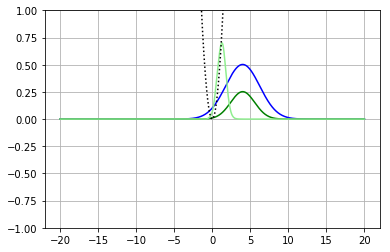

In [5]:
def getPropDens(f):
    return np.multiply(np.conj(f),f)

def timeEvolution(xGrid,initialWaveFunc,t,eigenValues,eigenFunctions):
    superposition = np.zeros(len(xGrid))
    for i in range(40):
        ef         = eigenFunctions[i]
        prod       = np.multiply(initialWaveFunc,ef)
        projection = integrate(xGrid,prod)
        phase      = np.exp(-complex(0, 1)*eigenValues[i]*t)
        superposition = np.add(superposition,projection*phase*ef)
    superpositionDens = getPropDens(superposition)
    return superpositionDens

initialWaveFunc = np.exp(-0.1*np.square(xGrid-4))
norm = np.sqrt(integrate(xGrid,np.multiply(initialWaveFunc,initialWaveFunc)))
initialWaveFunc = initialWaveFunc/norm
initialpropDensity = getPropDens(initialWaveFunc)
print('norm eigen states: ',[integrate(xGrid,np.multiply(eigenFunctions[i],eigenFunctions[i])) for i in range(3)])
print('norm initial state: ',integrate(xGrid,initialpropDensity))

t=2*np.pi*0.2
superpositionDens = timeEvolution(xGrid,initialWaveFunc,t,eigenValues,eigenFunctions)

plt.plot(xGrid,initialWaveFunc,color='blue')
plt.plot(xGrid,initialpropDensity,color='green')
plt.plot(xGrid,superpositionDens,color='lightgreen')
plt.plot(xGrid,getPotential(xGrid),linestyle=':',color='black')
plt.ylim((-1,1))
plt.grid()

In [274]:
np.exp(-complex(0, 1))

(0.5403023058681398-0.8414709848078965j)